In [1]:
import numpy as np
import tensorflow as tf
import h5py
import scipy
import matplotlib.pyplot as plt
import math
from tensorflow.python.framework import ops
from tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict, forward_propagation_for_predict

%matplotlib inline

/home/dyjng/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# 导入数据集
train_x_org, train_y_org, test_x_org, test_y_org, classes = load_dataset()
print(train_x_org.shape, '\n', train_y_org.shape, '\n', test_x_org.shape, '\n', test_y_org.shape)

(1080, 64, 64, 3) 
 (1, 1080) 
 (120, 64, 64, 3) 
 (1, 120)


y = 2


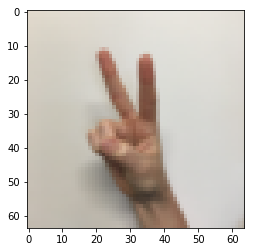

In [3]:
index = 999
plt.imshow(train_x_org[index])
print ("y = " + str(np.squeeze(train_y_org[:, index])))

In [4]:
train_x = train_x_org.reshape(train_x_org.shape[0], -1).T / 255
test_x = test_x_org.reshape(test_x_org.shape[0], -1).T / 255
train_y = convert_to_one_hot(train_y_org, 6)
test_y = convert_to_one_hot(test_y_org, 6)
print(train_x.shape, '\n', test_x.shape, '\n', train_y.shape, '\n', test_y.shape)

(12288, 1080) 
 (12288, 120) 
 (6, 1080) 
 (6, 120)


In [5]:
# 创建placeholder
def create_placeholder(nx, ny):
    x = tf.placeholder('float', shape=(nx, None))
    y = tf.placeholder('float', shape=(ny, None))
    return x, y

In [6]:
# tf.placeholder??

In [7]:
# 初始化参数
def init_params(layer_dims):
    params = {}
    L = len(layer_dims)
    for l in range(1, L):
        params["W" + str(l)] = tf.get_variable('W' + str(l), [layer_dims[l], layer_dims[l-1]], initializer=tf.contrib.layers.xavier_initializer())
        params["b" + str(l)] = tf.get_variable('b' + str(l), [layer_dims[l], 1], initializer=tf.zeros_initializer())
    
    return params

In [8]:
# tf.get_variable??

In [9]:
# 正向传播
def forward_prop(X, params):
    caches = {}
    caches["A0"] = X
    L = len(params) // 2
    for l in range(1, L):
        caches["Z" + str(l)] = tf.add(tf.matmul(params["W" + str(l)], caches["A" + str(l-1)]), params["b" + str(l)])
        caches["A" + str(l)] = tf.nn.relu(caches["Z" + str(l)])
    caches["Z" + str(L)] = tf.add(tf.matmul(params["W" + str(L)], caches["A" + str(L-1)]), params["b" + str(L)])
    ZL = caches["Z" + str(L)]
    
    return ZL, caches

In [10]:
# 代价函数
def cost_fun(ZL, Y):
    
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost= tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=logits))
    
    return cost

In [11]:
# tf.nn.softmax_cross_entropy_with_logits??

In [12]:
# 反向传播 求导
# tensorflow 自动完成
# optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
# optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)

In [41]:
# 定义模型
def model(train_x, train_y, test_x, test_y, layer_dims, batch_size = 32, 
          num_itera = 800, learning_rate = 0.0001, print_cost = False):
    
    ops.reset_default_graph()
    nx = train_x.shape[0]
    ny = train_y.shape[0]
    costs = []
    
    X, Y = create_placeholder(nx, ny)  # 占位符
    
    params = init_params(layer_dims)
    
    ZL, caches = forward_prop(X, params)
    
    cost = cost_fun(ZL, Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for i in range(num_itera):
            epoch_cost = 0
            mini_batches = random_mini_batches(train_x, train_y, batch_size)
            num_batch = len(mini_batches)
            for mini_batch in mini_batches:
                (minibatch_X, minibatch_Y) = mini_batch
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict = { X: minibatch_X, Y: minibatch_Y})
                epoch_cost += minibatch_cost / num_batch  # 平均损失
            
            if print_cost and i % 100 == 0:
                print("Cost in itera %i is %f" % (i, epoch_cost))
            
            if i % 10 == 0:
                costs.append(epoch_cost)
            
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per 10)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
        
        params = sess.run(params)
        print("参数训练完毕")
        
        correct_pred = tf.equal(tf.argmax(ZL), tf.argmax(Y))
        
        accuracy = tf.reduce_mean(tf.cast(correct_pred, "float"))
        
        train_acc = accuracy.eval({X: train_x, Y: train_y})
        test_acc = accuracy.eval({X: test_x, Y: test_y})
        
        print ("Train Accuracy:", train_acc)
        print ("Test Accuracy:", test_acc)
        
        return params

Cost in itera 0 is 1.811449
Cost in itera 100 is 0.628334
Cost in itera 200 is 0.246181
Cost in itera 300 is 0.123514
Cost in itera 400 is 0.040949
Cost in itera 500 is 0.094116
Cost in itera 600 is 0.036758
Cost in itera 700 is 0.026896


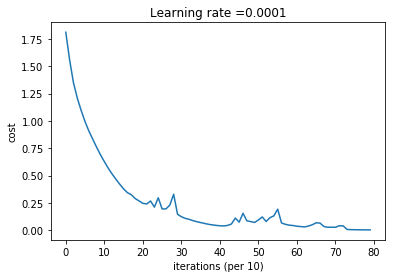

参数训练完毕
Train Accuracy: 1.0
Test Accuracy: 0.825


In [48]:
layer_dims = [12288, 100, 50, 25, 12, 6]

params = model(train_x, train_y, test_x, test_y, layer_dims, print_cost = True)

Your algorithm predicts: y = 3


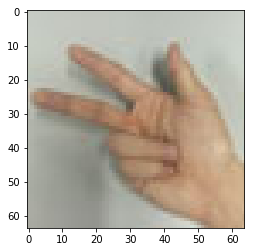

In [50]:
import scipy
from PIL import Image
from scipy import ndimage

## START CODE HERE ## (PUT YOUR IMAGE NAME) 
# my_image = "thumbs_up.jpg"
my_image = "dyj3.jpg"
## END CODE HERE ##

# We preprocess your image to fit your algorithm.
fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(64,64)).reshape((1, 64*64*3)).T
my_image_prediction = predict(my_image, params)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))